In [1]:
from dotenv import load_dotenv
import torch, logging

## disable warnings
logging.disable(logging.WARNING)  

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
import numpy as np
from tqdm.auto import tqdm

## For video display
from IPython.display import HTML, display

## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler

#import os
import gc

In [2]:
load_dotenv()
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

# Set the device to MPS (Metal Performance Shaders) for Apple Silicon Macs
# This allows for GPU acceleration on compatible devices
device = torch.device("mps")

True
True


In [3]:
def load_image(p):
    '''
    Function to load images from a defined path to Python Imaging Library (PIL) format
    '''
    # .resize((512,512)): This is the standard input size for Stable Diffusion v1.4
    return Image.open(p).convert('RGB').resize((512,512))

def convert_pil_to_latents(image):
    '''
    Function to convert PIL image to latents
    '''
    # 1. Convert PIL image to tensor
    # 2. .unsqueeze(0)
    #   * Adds a batch dimension to the tensor
    #   * Required for the VAE model which expects a batch of images
    # 3. Multiplying by 2.0  and subtracting 1.0: 
    #   * Normalizes pixel values from range [0, 1] to range [-1, 1]
    #   * This is the standard normalization for Stable Diffusion models
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = torch.clamp(init_image, -1.0, 1.0)  # Add clamping
    print(f"Tensor shape: {init_image.shape}")
    print(f"Tensor range: {init_image.min().item():.3f} to {init_image.max().item():.3f}")
    print(f"Tensor norm before MPS: {torch.norm(init_image).item():.3f}")

    init_image_mps = init_image.to(device="mps", dtype=torch.float16) 
    print(f"Tensor norm after MPS: {torch.norm(init_image_mps).item():.3f}")
   
    # 1. Encode the image to get the latent distribution
    # 2. Sample from the latent distribution (introduces stochasticity; alternative is .mode() for deterministic)
    # 3. Scale by 0.18215 to match the model's latent space (standard deviation of the latent space for Stable Diffusion v1.4)
    with torch.no_grad():
        try:
            # Get the latent distribution
            latent_dist = vae.encode(init_image_mps).latent_dist
            
            # Apply standard scaling
            init_latent_dist = latent_dist.sample() * 0.18215
                
            print(f"Final latent norm: {torch.norm(init_latent_dist).item():.3f}")
                
        except Exception as e:
            print(f"VAE encoding error: {e}")
            return None
        
    return init_latent_dist.to("mps")

def convert_latents_to_pil(latents):
    '''
    Convert latent space representations back to viewable PIL images.

    Args:
        latents (torch.Tensor): Latent space tensor with shape [batch_size, 4, height//8, width//8].
        Expected format: float16 tensor on MPS device, scaled by 0.18215.
        Example shapes: [1, 4, 64, 64] for 512x512 output images.
    
    Returns:
        list[PIL.Image]: List of PIL Image objects in RGB format.
    '''

    # 1. Scale the latents by 1 / 0.18215 to match the model's latent space
    latents = (1 / 0.18215) * latents
    # 2. Decode the latents using the VAE model to get the image tensor
    with torch.no_grad(): # Disables gradient computation (saves memory, faster inference)
        image = vae.decode(latents).sample
    # 3. Normalize the image tensor to range [0, 1]
    image = (image / 2 + 0.5).clamp(0, 1)
    # 4: Convert to numpy and rearrange dimensions
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    # 5. Convert the images to uint8 format for display
    images = (image * 255).round().astype("uint8")
    # 6: Create PIL images
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_encode(tokenizer, prompts, maxlen=None):
    """
    Convert text prompts into CLIP embeddings for diffusion model conditioning.
    
    Args:
        prompts (str or list[str]): Text prompt(s) to encode into embeddings.
        maxlen (int, optional): Maximum sequence length for tokenization.
            If None, uses tokenizer's default max length (typically 77 tokens).
            Longer prompts will be truncated, shorter ones padded.
            Defaults to None.
    
    Returns:
        torch.Tensor: CLIP text embeddings tensor with shape [batch_size, 77, 768].
            - batch_size: Number of prompts
            - 77: Maximum token sequence length (CLIP standard)
            - 768: Embedding dimension (feature vector size)
            Tensor is in float16 format on MPS device for memory efficiency.
    """

    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, 
                    padding="max_length", 
                    max_length=maxlen, 
                    truncation=True, 
                    return_tensors="pt"
                    ) 
    print(f"Tokenized input shape: {inp.input_ids.shape}")
    return text_encoder(inp.input_ids.to("mps"))[0].half()

def clear_memory():
    """
    Clear GPU memory cache and run garbage collection for Apple Silicon MPS.
    Helps prevent out-of-memory errors during long generation sequences
    """
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    gc.collect()

def generate_image(prompts, 
                   g=7.5, 
                   seed=100, 
                   steps=70, 
                   dim=512, 
                   save_int=True, 
                   input_image=None, 
                   strength=0.5, 
                   scheduler=None, 
                   unet=None,
                   tokenizer=None):
    """
    Generate images using Stable Diffusion with optional image-to-image conditioning.
    
    This function implements the complete diffusion pipeline: text encoding, image conditioning,
    iterative denoising, and final image conversion. It supports both text-to-image and 
    image-to-image generation with classifier-free guidance.
    
    Args:
            prompts (list[str]): List of text prompts describing the desired image(s).
            Example: ["A banana running with a cocktail glass"]
            
            g (float, optional): Guidance scale for classifier-free guidance. Higher values 
            follow the prompt more closely but may reduce creativity. Defaults to 7.5.
            Range: 1.0 (no guidance) to 20.0 (strong guidance)
            
            seed (int, optional): Random seed for reproducible generation. Same seed with 
            same parameters produces identical results. Defaults to 100.
            
            steps (int, optional): Number of denoising steps. More steps = better quality 
            but longer generation time. Defaults to 70.
            Range: 10-100 (typical: 20-50 for speed, 50-100 for quality)
            
            dim (int, optional): Output image dimension (square). Must be divisible by 8.
            Defaults to 512. Common values: 256, 384, 512, 768.
            
            save_int (bool, optional): Whether to save and display intermediate images 
            during generation (every 10 steps). Defaults to True.
            
            input_image (str, optional): Path to input image for image-to-image generation.
            If None, performs text-to-image generation. Defaults to None.
            Example: 'img/banana_logo.jpg'
            
            strength (float, optional): Denoising strength for img2img.
                0.0 = no change to input image
                1.0 = completely ignore input image (pure text2img)
                0.3-0.7 = typical range for style transfer
                Defaults to 0.5.
    
    Returns:
            list[PIL.Image]: List of generated PIL Images ready for display or saving.        
    """

    # Defining batch size
    bs = len(prompts) 

    # Converting textual prompts to embedding
    text = text_encode(tokenizer, prompts) 
    print(f"True Text embedding norm: {torch.norm(text).item():.3f}")

    # Adding an unconditional prompt, helps in the generation process
    uncond =  text_encode(tokenizer, [""] * bs, text.shape[1])
    print(f"Uncond embedding norm: {torch.norm(uncond).item():.3f}")
    emb = torch.cat([uncond, text], dim=0)
    print(f"Combined embedding shape: {emb.shape}")

    # convert image to embedding
    if input_image:
            image = load_image(input_image)
            image_emb = convert_pil_to_latents(image)
    else:
            image_emb = None

    # Setting the seed
    if seed: 
        torch.manual_seed(seed)

    # Handle image conditioning by modifying initial latents
    if image_emb is not None:

        scheduler.set_timesteps(steps)

        # Convert strength to proper noise strength
        # Higher strength = less noise added to image
        noise_strength = 1.0 - strength

        # Calculate which step to start denoising from
        start_step = int(steps * noise_strength)
        
        # Get the appropriate timestep for noise level
        init_timestep = scheduler.timesteps[start_step:start_step+1]
        init_timestep = init_timestep.to("mps")
        
        # Add appropriate amount of noise to the image embedding
        # The model is trying to learn the mean and variance of the noise at each timestep.
        noise = torch.randn_like(image_emb)
        latents = scheduler.add_noise(image_emb, noise, init_timestep).to("mps").half()
        
        # Use timesteps starting from the calculated step (skips early high-noise steps)
        timesteps = scheduler.timesteps[start_step:]
        
        print(f"Starting img2img from step {start_step}/{steps} (strength: {noise_strength:.2f})")
    else:
        # Pure text-to-image: start with random noise
        print("Starting text-to-image generation with random noise.")
        scheduler.set_timesteps(steps) 

        latents = torch.randn((bs, unet.config.in_channels, dim//8, dim//8), device="mps", dtype=torch.float16)
        latents = latents * scheduler.init_noise_sigma
     
        timesteps = scheduler.timesteps

    print("Processing text prompts:", prompts)
    # Initialize array to store norm values
    norm_history = []
    
    # Calculate and store initial norm
    initial_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    norm_history.append(initial_norm)
    print(f"Initial Latents Norm: {initial_norm}")

    clear_memory()

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(timesteps)):
            clear_memory()  # Clear before each step
            
            # We need to scale the i/p latents to match the variance
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            
            # Predicting noise residual using U-Net
            with torch.no_grad(): 
                    u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
            # Performing Guidance
            pred = u + g*(t-u)
            
            # Conditioning the latents
            latents = scheduler.step(pred, ts, latents).prev_sample

            # latent clamping
            latents = torch.clamp(latents, -10.0, 10.0) 

            # Calculate current norm
            current_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
            
            # Get previous norm from history
            previous_norm = norm_history[-1] if norm_history else current_norm
            
            # Store current norm in history
            norm_history.append(current_norm)

            print(f"Step {i+1}/{steps} Latents Norm: {current_norm:.3f}")

            # Check for divergence
            if current_norm > previous_norm * 1.5:
                print("Warning: Latents may be diverging!")

            if save_int and i%10==0: 
                    image_path = f'steps2/la_{i:04d}.jpeg'
                    convert_latents_to_pil(latents)[0].save(image_path)
                    display(convert_latents_to_pil(latents)[0])  # Display the new image

    # Print norm progression summary
    print(f"\nNorm progression: {norm_history[0]:.3f} → {norm_history[-1]:.3f}")

    return convert_latents_to_pil(latents)

In [4]:
model_path = "CompVis/stable-diffusion-v1-4"
torch_dtype = torch.float16

## Initiating tokenizer and encoder
tokenizer = CLIPTokenizer.from_pretrained(
    model_path, 
    subfolder="tokenizer"
)

text_encoder = CLIPTextModel.from_pretrained(
    model_path, 
    subfolder="text_encoder", 
    torch_dtype=torch_dtype
).to("mps")


## Initiating the VAE
vae = AutoencoderKL.from_pretrained(
    model_path,
    subfolder="vae",
    torch_dtype=torch_dtype,
    low_cpu_mem_usage=True
).to("mps")

## Initializing a scheduler and Setting number of sampling steps
# Utilize DDIMScheduler for better quality and speed (for inference)
scheduler = DDIMScheduler.from_pretrained(
    model_path,
    subfolder="scheduler"
)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained(
    model_path,
    subfolder="unet",
    torch_dtype=torch_dtype
).to("mps")

# Call this function before heavy operations
clear_memory()

<!-- Process:
    1. Text Encoding: Converts prompts to CLIP embeddings for conditioning
    2. Image Conditioning: Optionally encodes input image to latent space
    3. Noise Initialization: Creates random latents with optional image blending
    4. Iterative Denoising: Uses U-Net to progressively remove noise over 'steps'
    5. Guidance Application: Combines conditional and unconditional predictions
    6. Latent-to-Image: Converts final latents back to viewable images

Features:
    - Classifier-free guidance for better prompt adherence
    - Image-to-image generation with controllable influence
    - Memory management for Apple Silicon MPS
    - Progress monitoring with latent norm tracking
    - Intermediate image saving and display
    - Divergence detection for stability monitoring

Examples:
    # Text-to-image generation
    images = generate_image(["A sunset over mountains"], steps=25, seed=42)
    
    # Image-to-image with strong conditioning
    images = generate_image(
        prompts=["Turn this into a Van Gogh painting"],
        input_image="photo.jpg",
        src_img_influence=0.8,
        steps=30
    ) -->

Tokenized input shape: torch.Size([1, 77])
True Text embedding norm: 244.875
Tokenized input shape: torch.Size([1, 77])
Uncond embedding norm: 254.125
Combined embedding shape: torch.Size([2, 77, 768])
Starting text-to-image generation with random noise.
Processing text prompts: ['A dachshund dog on a Napoli street, wearing a red bandana, sharp focus on face, high detail, photorealistic, with Mount Vesuvius erupting in the background']
Initial Latents Norm: 127.75


  0%|          | 0/30 [00:00<?, ?it/s]

Step 1/30 Latents Norm: 127.625


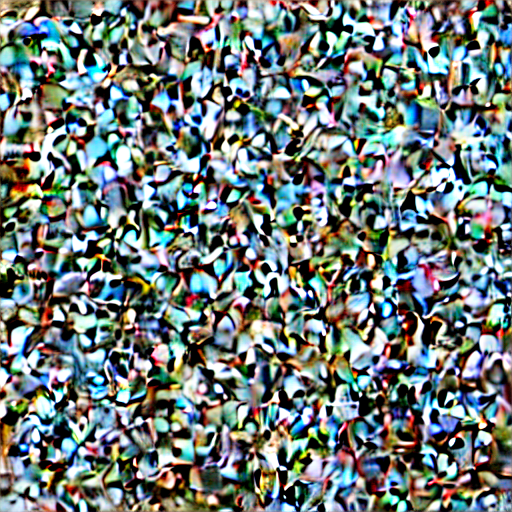

Step 2/30 Latents Norm: 127.438
Step 3/30 Latents Norm: 127.250
Step 4/30 Latents Norm: 127.062
Step 5/30 Latents Norm: 126.938
Step 6/30 Latents Norm: 126.688
Step 7/30 Latents Norm: 126.375
Step 8/30 Latents Norm: 126.000
Step 9/30 Latents Norm: 125.562
Step 10/30 Latents Norm: 125.188
Step 11/30 Latents Norm: 124.688


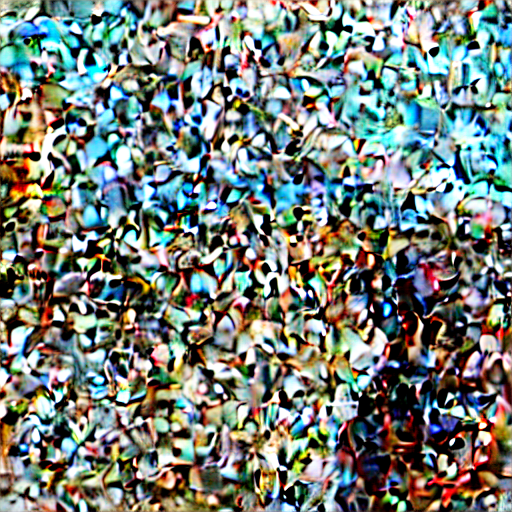

Step 12/30 Latents Norm: 124.188
Step 13/30 Latents Norm: 123.625
Step 14/30 Latents Norm: 123.062
Step 15/30 Latents Norm: 122.375
Step 16/30 Latents Norm: 121.688
Step 17/30 Latents Norm: 121.000
Step 18/30 Latents Norm: 120.188
Step 19/30 Latents Norm: 119.375
Step 20/30 Latents Norm: 118.500
Step 21/30 Latents Norm: 117.562


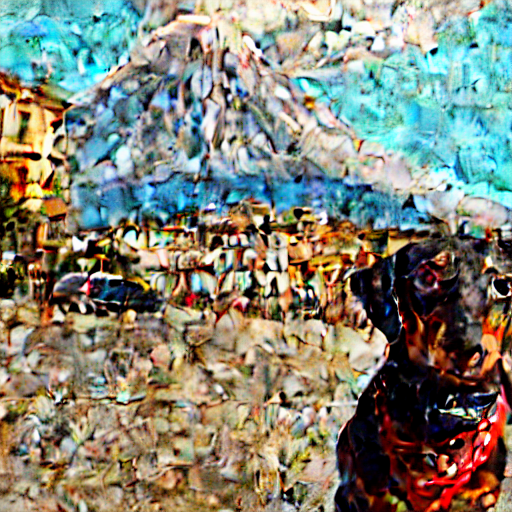

Step 22/30 Latents Norm: 116.688
Step 23/30 Latents Norm: 115.750
Step 24/30 Latents Norm: 114.812
Step 25/30 Latents Norm: 113.938
Step 26/30 Latents Norm: 113.062
Step 27/30 Latents Norm: 112.188
Step 28/30 Latents Norm: 111.250
Step 29/30 Latents Norm: 109.812
Step 30/30 Latents Norm: 109.812

Norm progression: 127.750 → 109.812


In [5]:

images = generate_image(prompts=["A dachshund dog on a Napoli street, wearing a red bandana, sharp focus on face, high detail, photorealistic, with Mount Vesuvius erupting in the background"], 
                        g=7.5, # guidance (0-20); g=7.5 is optimal for text-to-image; g>9 is optimal for img2img
                        seed=456,
                        steps=30, 
                        save_int=True, 
                        input_image=None, 
                        strength=1.0,  # Denoising strength for img2img; Low strength = preserve original, High strength = more transformation
                        scheduler=scheduler,
                        unet=unet,
                        tokenizer=tokenizer
                        )

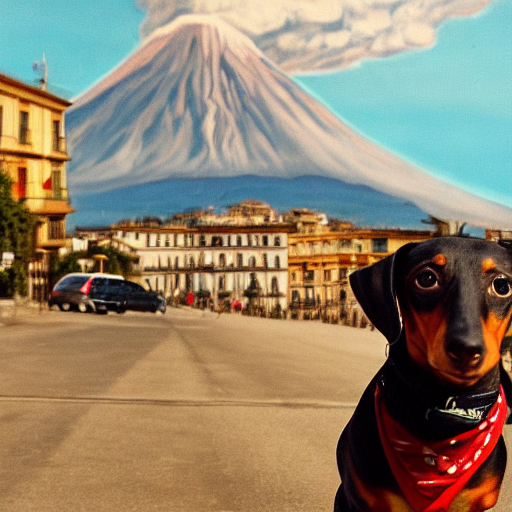

In [6]:
for img in images:
    display(img)